## Homework 4 : Comparative Analysis of Vision Transformer and SWIN Models for Image Classification


---
> **Student ID:** 313831002


> **Student Name:** Pavan Kumar J | 柯奉煌

> **Course Name:** Recurrent Neural Networks

> **Instructor:** 黃仁竑 


### Import Statements

In [1]:
# Cell 1: Imports & Device Setup
import os
import time
import math
import numpy as np
from scipy.ndimage import zoom
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import CosineAnnealingLR
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
import timm
from PIL import Image

### Check for GPU

In [53]:
if torch.cuda.is_available():
    device = 'cuda'
    print("[INFO] Current device:", torch.cuda.get_device_name(torch.cuda.current_device()), f", device num:{torch.cuda.current_device()}")
elif torch.has_mps:
    device = 'mps'
    print("[INFO] Current device: MAC OS Metal Performance Shaders.")
else:
    device = 'cpu'
    print("[INFO] Current device: CPU")
    print("*"*50,"\n[WARNING] You may need to change the device to GPU or MPS to get better performance.")
    print("*"*50)
device = torch.device(device)

[INFO] Current device: NVIDIA GeForce RTX 4090 , device num:0


### Data Preparation

In [ ]:
# CIFAR-10 class labels
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
# Data Preprocessing & Dataloaders
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2470, 0.2435, 0.2616))
])
full_train = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
train_size = int(0.8 * len(full_train))
val_size = len(full_train) - train_size
train_set, val_set = torch.utils.data.random_split(full_train, [train_size, val_size])
train_loader = torch.utils.data.DataLoader(train_set, batch_size=32, shuffle=True, num_workers=8)
val_loader = torch.utils.data.DataLoader(val_set, batch_size=32, shuffle=False, num_workers=8)
test_set = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=32, shuffle=False, num_workers=8)

Files already downloaded and verified
Files already downloaded and verified


### Model Definitions

In [ ]:
class SwinHead(nn.Module):
    def __init__(self, in_channels, num_classes):
        super().__init__()
        self.global_pool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Linear(in_channels, num_classes)
    def forward(self, x):
        x = x.permute(0, 3, 1, 2)
        x = self.global_pool(x)
        x = x.flatten(1)
        return self.fc(x)

def create_vit(num_classes=10, pretrained=True):
    model = timm.create_model('vit_base_patch32_224', pretrained=pretrained)
    model.head = nn.Linear(model.head.in_features, num_classes)
    return model

def create_swin(num_classes=10, pretrained=True):
    model = timm.create_model('swin_base_patch4_window7_224.ms_in1k', pretrained=pretrained)
    model.head = SwinHead(in_channels=1024, num_classes=num_classes)
    return model

### Training & Evaluation Utilities

In [ ]:
def setup_model_training(model, option="full_finetune"):
    if option == "full_finetune":
        return model.parameters()
    for param in model.parameters(): param.requires_grad = False
    for param in model.head.parameters(): param.requires_grad = True
    if hasattr(model, 'layers') and model.layers:
        for param in model.layers[-1].parameters(): param.requires_grad = True
    return filter(lambda p: p.requires_grad, model.parameters())

def train_model(model, train_loader, val_loader, criterion, optimizer,
                epochs=20, name="model", out_dir="."):
    history = {'train_loss':[], 'train_acc':[], 'val_loss':[], 'val_acc':[]}
    scheduler = CosineAnnealingLR(optimizer, T_max=epochs, eta_min=1e-6)
    os.makedirs(out_dir, exist_ok=True)
    best_acc = 0.0
    for ep in range(epochs):
        model.train()
        r_loss, corr, tot = 0.0, 0, 0
        for imgs, labels in train_loader:
            imgs, labels = imgs.to(device), labels.to(device)
            optimizer.zero_grad()
            outs = model(imgs)
            loss = criterion(outs, labels)
            loss.backward()
            optimizer.step()
            r_loss += loss.item()
            preds = outs.argmax(1)
            corr += (preds == labels).sum().item()
            tot += labels.size(0)
        scheduler.step()
        tr_loss, tr_acc = r_loss/len(train_loader), 100*corr/tot
        val_loss, val_acc, _ = evaluate_model(model, val_loader, criterion, compute_metrics=False)
        history['train_loss'].append(tr_loss)
        history['train_acc'].append(tr_acc)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)
        print(f"Epoch {ep+1}/{epochs} | Train Acc: {tr_acc:.2f}% | Val Acc: {val_acc:.2f}% | LR: {optimizer.param_groups[0]['lr']:.6f}")
        if val_acc > best_acc:
            best_acc = val_acc
            torch.save(model.state_dict(), f"{out_dir}/best_{name}.pth")
    torch.save(model.state_dict(), f"{out_dir}/final_{name}.pth")
    return history

def evaluate_model(model, loader, criterion=None, compute_metrics=True,
                   plot_confusion=False, name="model", out_dir="."):
    model.eval()
    all_preds, all_labels = [], []
    run_loss, corr, tot = 0.0, 0, 0
    inf_time, batches = 0.0, 0
    os.makedirs(out_dir, exist_ok=True)
    with torch.no_grad():
        for imgs, labels in loader:
            imgs, labels = imgs.to(device), labels.to(device)
            start = time.time()
            outs = model(imgs)
            inf_time += time.time() - start
            batches += 1
            if criterion:
                run_loss += criterion(outs, labels).item()
            preds = outs.argmax(1)
            corr += (preds == labels).sum().item()
            tot += labels.size(0)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    acc = 100*corr/tot
    avg_loss = run_loss/len(loader) if criterion else None
    avg_inf = inf_time/batches
    if compute_metrics:
        print(f"{name} | Acc: {acc:.2f}% | Time/batch: {avg_inf*1000:.1f}ms")
        print(classification_report(all_labels, all_preds, target_names=classes, digits=3))
        if plot_confusion:
            cm = confusion_matrix(all_labels, all_preds)
            plt.figure(figsize=(8,6))
            sns.heatmap(cm, annot=True, fmt='d', xticklabels=classes, yticklabels=classes)
            plt.title(f"{name} Confusion Matrix")
            plt.savefig(f"{out_dir}/{name}_cm.png")
            plt.close()
    return avg_loss, acc, avg_inf

### GradCAM implementation

In [ ]:
# Custom SWIN head class
class SwinHead(nn.Module):
    def __init__(self, in_channels, num_classes):
        super(SwinHead, self).__init__()
        self.global_pool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Linear(in_channels, num_classes)

    def forward(self, x):
        x = x.permute(0, 3, 1, 2)  # This is crucial for SWIN - converting [B,H,W,C] to [B,C,H,W]
        x = self.global_pool(x)
        x = x.flatten(1)
        x = self.fc(x)
        return x

# Transform functions for GradCAM
class ReshapeTransformViT:
    """Reshape transform for ViT models."""
    def __init__(self, model):
        # For standard ViT models from timm
        if hasattr(model, 'patch_embed'):
            if hasattr(model.patch_embed, 'img_size'):
                # For timm implementation
                input_size = model.patch_embed.img_size
                patch_size = model.patch_embed.patch_size
                if isinstance(input_size, tuple):
                    self.h = input_size[0] // patch_size[0]
                    self.w = input_size[1] // patch_size[1]
                else:
                    self.h = input_size // patch_size
                    self.w = input_size // patch_size
            else:
                # Fallback for older models or different implementations
                # Assuming square patches for a 224x224 image with patch_size 16 (14x14 grid)
                self.h = 14
                self.w = 14
        else:
            # Default for 224x224 image with 16x16 patches
            self.h = 14
            self.w = 14

    def __call__(self, x):
        # Remove cls token and reshape
        # [batch_size, num_tokens, token_dim]
        result = x[:, 1:, :].reshape(x.size(0),
                                     self.h,
                                     self.w,
                                     x.size(2))

        # Bring the channels to the first dimension,
        # like in CNNs.
        # [batch_size, H, W, C] -> [batch, C, H, W]
        result = result.permute(0, 3, 1, 2)
        return result

class ResizeTransformSwin:
    """Reshape transform for Swin transformer."""
    def __init__(self, im_h, im_w):
        self.height = self.feature_size(im_h)
        self.width = self.feature_size(im_w)

    @staticmethod
    def feature_size(s):
        s = math.ceil(s / 4)  # PatchEmbed
        s = math.ceil(s / 2)  # PatchMerging1
        s = math.ceil(s / 2)  # PatchMerging2
        s = math.ceil(s / 2)  # PatchMerging3
        return s

    def __call__(self, x):
        result = x.reshape(x.size(0),
                           self.height,
                           self.width,
                           x.size(2))

        # Bring the channels to the first dimension,
        # like in CNNs.
        # [batch_size, H, W, C] -> [batch, C, H, W]
        result = result.permute(0, 3, 1, 2)
        return result

# GradCAM implementation
class GradCAM:
    def __init__(self, model, target_layers, reshape_transform=None, use_cuda=False):
        self.model = model
        self.target_layers = target_layers
        self.reshape_transform = reshape_transform
        self.cuda = use_cuda
        self.activations = []
        self.gradients = []
        self.handles = []
        
        if self.cuda:
            self.model = model.cuda()
        
        # Register hooks
        self._register_hooks()
        
    def _register_hooks(self):
        def forward_hook(module, input, output):
            self.activations.append(output)
        
        def backward_hook(module, grad_in, grad_out):
            self.gradients.append(grad_out[0])
        
        # Register forward and backward hooks
        for target_layer in self.target_layers:
            self.handles.append(target_layer.register_forward_hook(forward_hook))
            self.handles.append(target_layer.register_full_backward_hook(backward_hook))
    
    def __call__(self, input_tensor, target_category=None):
        if self.cuda:
            input_tensor = input_tensor.cuda()
        
        # Forward pass
        model_output = self.model(input_tensor)
        
        if target_category is None:
            target_category = torch.argmax(model_output, dim=1).item()
        
        # Zero gradients
        self.model.zero_grad()
        
        # Target for backprop
        one_hot = torch.zeros_like(model_output)
        one_hot[0, target_category] = 1
        
        # Backward pass
        model_output.backward(gradient=one_hot, retain_graph=True)
        
        # Get activations and reshape if needed
        activations = self.activations.pop()
        if self.reshape_transform is not None:
            activations = self.reshape_transform(activations)
        
        # Get gradients and reshape if needed
        gradients = self.gradients.pop()
        if self.reshape_transform is not None:
            gradients = self.reshape_transform(gradients)
        
        # Global average pooling of gradients
        weights = torch.mean(gradients, dim=[2, 3], keepdim=True)
        
        # Weight the activations
        cam = torch.sum(weights * activations, dim=1, keepdim=True)
        
        # ReLU and normalize
        cam = torch.relu(cam)
        cam = cam / (torch.max(cam) + 1e-7)
        
        # Resize to input size
        cam = cam.squeeze().cpu().data.numpy()
        
        return cam

# Utility functions
def center_crop_img(img, size):
    h, w = img.shape[0], img.shape[1]
    if h > size and w > size:
        j = int(round((h - size) / 2.))
        i = int(round((w - size) / 2.))
        img = img[j:j+size, i:i+size]
    return img

def show_cam_on_image(img, mask, use_rgb=False, colormap=plt.cm.jet):
    """
    Create a heatmap overlay using a mask on an image.
    
    Args:
        img: Original image (normalized to [0, 1])
        mask: Attention mask (normalized to [0, 1])
        use_rgb: Whether to use RGB colors or colormap
        colormap: Colormap to use
    """
    if len(img.shape) == 2:
        img = np.repeat(img[:, :, np.newaxis], 3, axis=2)
    
    # Resize mask to match image dimensions if needed
    if mask.shape[0] != img.shape[0] or mask.shape[1] != img.shape[1]:
        mask = zoom(mask, (img.shape[0] / mask.shape[0], img.shape[1] / mask.shape[1]), order=1)
    
    heatmap = colormap(mask)[:, :, :3]
    
    if use_rgb:
        cam_result = heatmap + img
        cam_result = cam_result / np.max(cam_result)
    else:
        cam_result = (heatmap * 0.3 + img * 0.7)
    
    return cam_result

# CIFAR-10 specific denormalization function
def denormalize_cifar10(image):
    """
    Restore images normalized using CIFAR-10 standardization parameters 
    (0.4914, 0.4822, 0.4465), (0.2470, 0.2435, 0.2616) back to their original form.
    
    Args:
        image: Normalized image with shape [C, H, W] or [H, W, C]
    
    Returns:
        Denormalized image with values in the range 0-1
    """
    # Check if channels are in the first dimension
    is_chw = image.shape[0] == 3 and len(image.shape) == 3
    
    mean = np.array([0.4914, 0.4822, 0.4465])
    std = np.array([0.2470, 0.2435, 0.2616])
    
    if is_chw:
        # If the format is [C, H, W]
        for i in range(3):
            image[i] = image[i] * std[i] + mean[i]
    else:
        # If the format is [H, W, C]
        image = image * std + mean
    
    # Ensure values are within the range 0-1 
    # (some values might exceed the range due to numerical calculations)
    image = np.clip(image, 0, 1)
    
    return image

def load_trained_models():
    """Load all trained models"""
    models = {}
    model_names = []
    
    
    try:
        # Load ViT with head-only fine-tuning
        vit_head = timm.create_model('vit_base_patch32_224', pretrained=False)
        vit_head.head = nn.Linear(vit_head.head.in_features, 10)
        vit_head.load_state_dict(torch.load("runs/vit_head/final_vit_head.pth"))
        vit_head.to(device)
        vit_head.eval()
        models["ViT (Head)"] = vit_head
        model_names.append("ViT (Head)")
        print("Loaded ViT (Head-only fine-tuning) model")
    except Exception as e:
        print(f"Error loading ViT head model: {e}")
    
    try:
        # Load ViT with full fine-tuning
        vit_full = timm.create_model('vit_base_patch32_224', pretrained=False)
        vit_full.head = nn.Linear(vit_full.head.in_features, 10)
        vit_full.load_state_dict(torch.load("runs/vit_full/final_vit_full.pth"))
        vit_full.to(device)
        vit_full.eval()
        models["ViT (Full)"] = vit_full
        model_names.append("ViT (Full)")
        print("Loaded ViT (Full fine-tuning) model")
    except Exception as e:
        print(f"Error loading ViT full model: {e}")
    
    try:
        # Load SWIN with full fine-tuning
        swin_full = timm.create_model('swin_base_patch4_window7_224', pretrained=False)
        swin_full.head = SwinHead(in_channels=1024, num_classes=10)
        swin_full.load_state_dict(torch.load("runs/swin_head/final_swin_head.pth"))
        swin_full.to(device)
        swin_full.eval()
        models["SWIN (Head)"] = swin_full
        model_names.append("SWIN (Head)")
        print("Loaded SWIN (Head-only fine-tuning) model")
    except Exception as e:
        print(f"Error loading SWIN Head-Only model: {e}")
    
    try:
        # Load SWIN with head-only fine-tuning
        swin_head = timm.create_model('swin_base_patch4_window7_224', pretrained=False)
        swin_head.head = SwinHead(in_channels=1024, num_classes=10)
        swin_head.load_state_dict(torch.load("runs/swin_full/final_swin_full.pth"))
        swin_head.to(device)
        swin_head.eval()
        models["SWIN (Full)"] = swin_head
        model_names.append("SWIN (Full)")
        print("Loaded SWIN (Full fine-tuning) model")
    except Exception as e:
        print(f"Error loading SWIN Full model: {e}")
    
    return models, model_names

def get_vit_gradcam(model, input_tensor, target_category=None):
    """
    Get GradCAM visualization for ViT model
    """
    # Use the last transformer block's norm1 layer for attention
    target_layers = [model.blocks[-1].norm1]
    
    try:
        cam = GradCAM(
            model=model,
            target_layers=target_layers,
            reshape_transform=ReshapeTransformViT(model),
            use_cuda=torch.cuda.is_available()
        )
        
        grayscale_cam = cam(input_tensor=input_tensor, target_category=target_category)
        
        # Debug information
        #print(f"ViT GradCAM shape: {grayscale_cam.shape}")
        
        return grayscale_cam
    except Exception as e:
        print(f"Error in get_vit_gradcam: {e}")
        # Fallback to a simple approach
        with torch.no_grad():
            # Get features from the last block
            features = []
            def hook_fn(module, input, output):
                features.append(output)
            
            handle = model.blocks[-1].register_forward_hook(hook_fn)
            _ = model(input_tensor)
            handle.remove()
            
            if not features:
                # Create a default attention map
                return np.ones((7, 7)) * 0.5
            
            # Process features to get attention
            feature = features[0]  # Shape: [batch, tokens, channels]
            
            # Remove CLS token
            patch_features = feature[:, 1:, :]
            
            # Calculate importance using L2 norm
            importance = torch.norm(patch_features, dim=2)[0].cpu().numpy()
            
            # Reshape to spatial dimensions (assuming square image)
            size = int(np.sqrt(importance.shape[0]))
            heatmap = importance.reshape(size, size)
            
            # Normalize
            heatmap = heatmap - np.min(heatmap)
            heatmap = heatmap / np.max(heatmap) if np.max(heatmap) > 0 else heatmap
            
            print(f"Fallback ViT heatmap shape: {heatmap.shape}")
            
            return heatmap

def get_swin_gradcam(model, input_tensor, target_category=None):
    """
    Get GradCAM visualization for SWIN model
    """
    try:
        # Ensure input tensor is on the same device as the model
        model_device = next(model.parameters()).device
        input_tensor = input_tensor.to(model_device)
        
        # Extract features directly and use them as the attention map
        features = []
        
        def hook_fn(module, input, output):
            features.append(output)
            
        # Register hook on the final norm layer
        handle = model.norm.register_forward_hook(hook_fn)
        
        # Forward pass
        with torch.no_grad():
            _ = model(input_tensor)
        
        # Remove hook
        handle.remove()
        
        if not features:
            print("No features captured from SWIN model")
            return np.ones((7, 7)) * 0.5
        
        # Get feature tensor
        feature_tensor = features[0]
        #print(f"SWIN feature shape: {feature_tensor.shape}")
        
        # SWIN features are typically [batch, h, w, channels] or [batch, h*w, channels]
        if len(feature_tensor.shape) == 3:
            # Shape is [batch, h*w, channels]
            # Reshape to spatial grid
            grid_size = int(np.sqrt(feature_tensor.shape[1]))
            feature_tensor = feature_tensor.reshape(feature_tensor.shape[0], grid_size, grid_size, feature_tensor.shape[2])
        
        # Calculate feature importance using L2 norm across channel dimension
        feature_importance = torch.norm(feature_tensor[0], dim=-1).cpu().numpy()
        
        # Normalize the attention map
        heatmap = feature_importance
        heatmap = heatmap - np.min(heatmap)
        heatmap = heatmap / np.max(heatmap) if np.max(heatmap) > 0 else heatmap
        
        #print(f"SWIN heatmap shape: {heatmap.shape}")
        
        return heatmap
        
    except Exception as e:
        print(f"Error in get_swin_gradcam: {e}")
        # Return a default heatmap if everything fails
        return np.ones((7, 7)) * 0.5

def visualize_models_attention():
    """Generate and visualize attention maps for all models using GradCAM"""
    print("Loading trained models...")
    models, model_names = load_trained_models()
    
    if not models:
        print("No models were successfully loaded. Cannot continue with visualization.")
        return
    
    print("Getting test samples...")
    testloader = setup_data()
    samples = get_random_test_samples(testloader, num_samples=10)
    
    # Create output directory
    output_dir = "visualizations/attention_maps"
    os.makedirs(output_dir, exist_ok=True)
    
    # Create a figure for visualization
    fig, axes = plt.subplots(len(samples), len(models) + 1, figsize=(5*(len(models) + 1), 5*len(samples)))
    
    for i, (image, label) in enumerate(samples):
        # Original image
        image = image.to(device)
        orig_img = image.cpu().squeeze().numpy().transpose(1, 2, 0)
        
        orig_img = denormalize_cifar10(orig_img)
        
        # Display original image
        if len(samples) > 1:
            axes[i, 0].imshow(orig_img)
            axes[i, 0].set_title(f"Original: {classes[label]}", fontsize=12)
            axes[i, 0].axis('off')
        else:
            axes[0].imshow(orig_img)
            axes[0].set_title(f"Original: {classes[label]}", fontsize=12)
            axes[0].axis('off')
        
        # For each model, generate appropriate attention map
        for j, (model_name, model) in enumerate(models.items()):
            try:
                # Ensure model is in eval mode
                model.eval()
                
                # Use appropriate feature map based on model type
                if "swin" in model_name.lower():
                    grayscale_cam = get_swin_gradcam(model, image)
                else:
                    grayscale_cam = get_vit_gradcam(model, image)
                
                # Create overlay
                heatmap = show_cam_on_image(orig_img, grayscale_cam, use_rgb=True)
                
                # Get model prediction
                with torch.no_grad():
                    # Ensure input is on the same device as model
                    model_device = next(model.parameters()).device
                    img_input = image.to(model_device)
                    
                    output = model(img_input)
                    _, predicted = torch.max(output, 1)
                    probs = torch.nn.functional.softmax(output, dim=1)
                    confidence = probs[0, predicted.item()].item() * 100
                
                # Display result
                ax_idx = j + 1
                if len(samples) > 1:
                    axes[i, ax_idx].imshow(heatmap)
                    correct = "✓" if predicted.item() == label else "✗"
                    axes[i, ax_idx].set_title(
                        f"{model_name}\nPred: {classes[predicted.item()]} {correct}\nConf: {confidence:.1f}%", 
                        fontsize=12
                    )
                    axes[i, ax_idx].axis('off')
                else:
                    axes[ax_idx].imshow(heatmap)
                    correct = "✓" if predicted.item() == label else "✗"
                    axes[ax_idx].set_title(
                        f"{model_name}\nPred: {classes[predicted.item()]} {correct}\nConf: {confidence:.1f}%", 
                        fontsize=12
                    )
                    axes[ax_idx].axis('off')
                
            except Exception as e:
                print(f"Error processing {model_name} for sample {i}: {e}")
                # Display error message
                if len(samples) > 1:
                    axes[i, j+1].text(0.5, 0.5, f"Error: {str(e)[:50]}...", ha='center', va='center')
                    axes[i, j+1].axis('off')
                else:
                    axes[j+1].text(0.5, 0.5, f"Error: {str(e)[:50]}...", ha='center', va='center')
                    axes[j+1].axis('off')
    
    plt.tight_layout()
    plt.savefig(f"{output_dir}/attention_visualization.png", dpi=200, bbox_inches='tight')
    print(f"Saved attention visualizations to {output_dir}/attention_visualization.png")
    plt.show()



### ViT Head-only Training

In [ ]:
print("\n=== Training ViT Transformer (head-only fine-tuning) ===")
vit_head = create_vit(pretrained=True).to(device)
criterion = nn.CrossEntropyLoss()
opt_vit_head = optim.AdamW(setup_model_training(vit_head, 'head_only'), lr=1e-3)
history_vit_head = train_model(vit_head, train_loader, val_loader, criterion, opt_vit_head,
                              epochs=20, name='vit_head', out_dir='runs/vit_head')


=== Training ViT Transformer (head-only fine-tuning) ===
Epoch 1/20 | Train Acc: 92.04% | Val Acc: 93.61% | LR: 0.000994
Epoch 2/20 | Train Acc: 94.18% | Val Acc: 93.77% | LR: 0.000976
Epoch 3/20 | Train Acc: 94.80% | Val Acc: 93.81% | LR: 0.000946
Epoch 4/20 | Train Acc: 95.11% | Val Acc: 92.92% | LR: 0.000905
Epoch 5/20 | Train Acc: 95.39% | Val Acc: 93.40% | LR: 0.000854
Epoch 6/20 | Train Acc: 95.68% | Val Acc: 93.74% | LR: 0.000794
Epoch 7/20 | Train Acc: 95.92% | Val Acc: 93.60% | LR: 0.000727
Epoch 8/20 | Train Acc: 96.08% | Val Acc: 93.28% | LR: 0.000655
Epoch 9/20 | Train Acc: 96.27% | Val Acc: 93.78% | LR: 0.000579
Epoch 10/20 | Train Acc: 96.47% | Val Acc: 93.72% | LR: 0.000501
Epoch 11/20 | Train Acc: 96.72% | Val Acc: 93.60% | LR: 0.000422
Epoch 12/20 | Train Acc: 96.92% | Val Acc: 93.61% | LR: 0.000346
Epoch 13/20 | Train Acc: 97.07% | Val Acc: 93.59% | LR: 0.000274
Epoch 14/20 | Train Acc: 97.26% | Val Acc: 93.65% | LR: 0.000207
Epoch 15/20 | Train Acc: 97.36% | Val Acc

### ViT Head-only Evaluation

In [ ]:
print("\n=== Evaluating ViT Transformer (head-only fine-tuning) ===")
vit_head.load_state_dict(torch.load('runs/vit_head/final_vit_head.pth'))
evaluate_model(vit_head, test_loader, criterion, compute_metrics=True, plot_confusion=True,
               name='ViT Head', out_dir='runs/vit_head')



=== Evaluating ViT Transformer (head-only fine-tuning) ===


C:\Users\user\AppData\Local\Temp\ipykernel_74760\1557119670.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  vit_head.load_state_dict(torch.load('runs/vit_head/final_vit_

ViT Head | Acc: 93.52% | Time/batch: 3.2ms
              precision    recall  f1-score   support

       plane      0.940     0.951     0.945      1000
         car      0.945     0.954     0.949      1000
        bird      0.953     0.937     0.945      1000
         cat      0.858     0.847     0.853      1000
        deer      0.944     0.954     0.949      1000
         dog      0.882     0.892     0.887      1000
        frog      0.952     0.965     0.958      1000
       horse      0.970     0.955     0.962      1000
        ship      0.960     0.954     0.957      1000
       truck      0.950     0.943     0.946      1000

    accuracy                          0.935     10000
   macro avg      0.935     0.935     0.935     10000
weighted avg      0.935     0.935     0.935     10000



(0.22727016835494307, 93.52, 0.003226837791954747)

### ViT Head-only Graphs 


=== Generating Training Curves and GradCAM for ViT Head ===


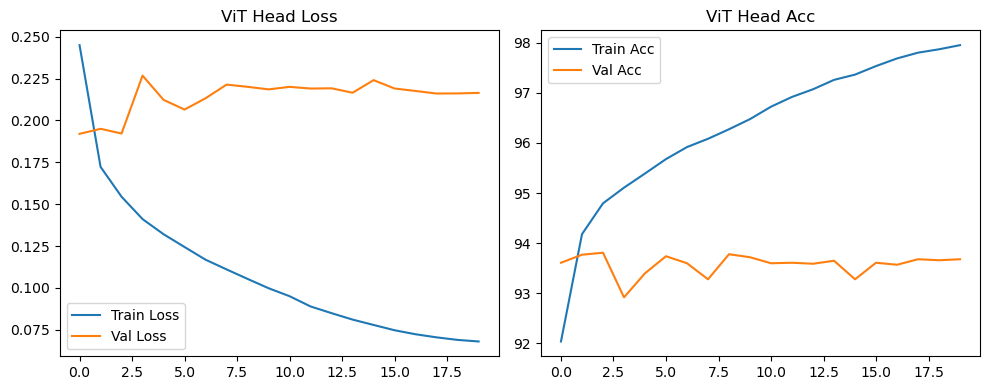

In [ ]:
print("\n=== Generating Training Curves and GradCAM for ViT Head ===")
# Plot training curves
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(history_vit_head['train_loss'], label='Train Loss')
plt.plot(history_vit_head['val_loss'], label='Val Loss')
plt.legend(); plt.title('ViT Head Loss')
plt.subplot(1,2,2)
plt.plot(history_vit_head['train_acc'], label='Train Acc')
plt.plot(history_vit_head['val_acc'], label='Val Acc')
plt.legend(); plt.title('ViT Head Acc')
plt.tight_layout(); plt.savefig('runs/vit_head/curves.png')


In [33]:
# Cell 9: SWIN Head-only Training
print("\n=== Training Swin Transformer (head-only fine-tuning) ===")
swin_head = create_swin(pretrained=True).to(device)
opt_swin_head = optim.AdamW(setup_model_training(swin_head, 'head_only'), lr=1e-3)
history_swin_head = train_model(swin_head, train_loader, val_loader, criterion, opt_swin_head,
                                epochs=20, name='swin_head', out_dir='runs/swin_head')


=== Training Swin Transformer (head-only fine-tuning) ===
Epoch 1/20 | Train Acc: 92.22% | Val Acc: 93.99% | LR: 0.000994
Epoch 2/20 | Train Acc: 94.38% | Val Acc: 94.27% | LR: 0.000976
Epoch 3/20 | Train Acc: 95.09% | Val Acc: 94.62% | LR: 0.000946
Epoch 4/20 | Train Acc: 95.67% | Val Acc: 94.56% | LR: 0.000905
Epoch 5/20 | Train Acc: 96.11% | Val Acc: 95.10% | LR: 0.000854
Epoch 6/20 | Train Acc: 96.62% | Val Acc: 95.34% | LR: 0.000794
Epoch 7/20 | Train Acc: 97.00% | Val Acc: 95.56% | LR: 0.000727
Epoch 8/20 | Train Acc: 97.52% | Val Acc: 95.44% | LR: 0.000655
Epoch 9/20 | Train Acc: 98.00% | Val Acc: 94.73% | LR: 0.000579
Epoch 10/20 | Train Acc: 98.30% | Val Acc: 95.11% | LR: 0.000501
Epoch 11/20 | Train Acc: 98.62% | Val Acc: 95.52% | LR: 0.000422
Epoch 12/20 | Train Acc: 98.92% | Val Acc: 95.62% | LR: 0.000346
Epoch 13/20 | Train Acc: 99.26% | Val Acc: 95.94% | LR: 0.000274
Epoch 14/20 | Train Acc: 99.39% | Val Acc: 95.93% | LR: 0.000207
Epoch 15/20 | Train Acc: 99.50% | Val Ac

In [38]:
# Cell 10: SWIN Head-only Evaluation
print("\n=== Evaluating Swin Transformer (head-only fine-tuning) ===")
swin_head.load_state_dict(torch.load('runs/swin_head/final_swin_head.pth'))
evaluate_model(swin_head, test_loader, criterion, compute_metrics=True, plot_confusion=True,
               name='SWIN Head', out_dir='runs/swin_head')


=== Evaluating Swin Transformer (head-only fine-tuning) ===


C:\Users\user\AppData\Local\Temp\ipykernel_74760\3046923470.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  swin_head.load_state_dict(torch.load('runs/swin_head/final_sw

SWIN Head | Acc: 95.55% | Time/batch: 12.7ms
              precision    recall  f1-score   support

       plane      0.956     0.968     0.962      1000
         car      0.964     0.978     0.971      1000
        bird      0.954     0.951     0.952      1000
         cat      0.909     0.896     0.902      1000
        deer      0.960     0.951     0.955      1000
         dog      0.929     0.936     0.932      1000
        frog      0.964     0.975     0.970      1000
       horse      0.971     0.969     0.970      1000
        ship      0.981     0.964     0.972      1000
       truck      0.968     0.967     0.967      1000

    accuracy                          0.956     10000
   macro avg      0.955     0.956     0.955     10000
weighted avg      0.955     0.956     0.955     10000



(0.23033979651869468, 95.55, 0.012726307677003904)


=== Generating Training Curves and GradCAM for SWIN Head ===


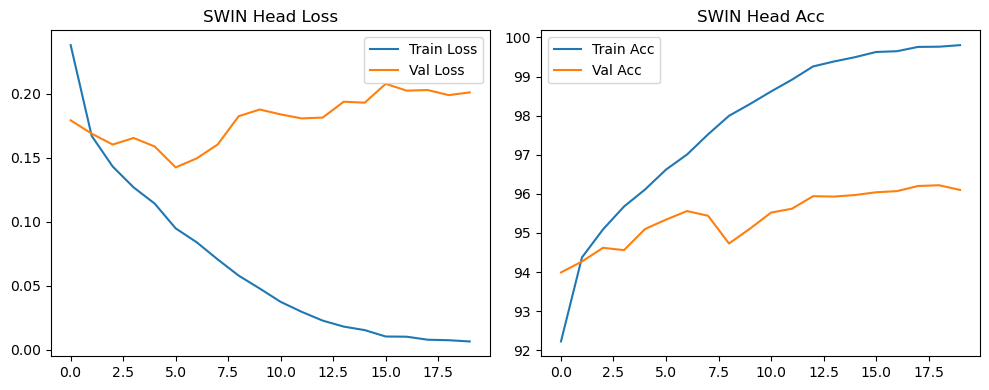

In [39]:
# Cell 11: SWIN Head-only Graphs & GradCAM
print("\n=== Generating Training Curves and GradCAM for SWIN Head ===")
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(history_swin_head['train_loss'], label='Train Loss')
plt.plot(history_swin_head['val_loss'], label='Val Loss')
plt.legend(); plt.title('SWIN Head Loss')
plt.subplot(1,2,2)
plt.plot(history_swin_head['train_acc'], label='Train Acc')
plt.plot(history_swin_head['val_acc'], label='Val Acc')
plt.legend(); plt.title('SWIN Head Acc')
plt.tight_layout(); plt.savefig('runs/swin_head/curves.png')



In [42]:
# Cell 12: ViT Full Fine-tuning Training
print("\n=== Training ViT Transformer (full fine-tuning) ===")
vit_full = create_vit(pretrained=True).to(device)
opt_vit_full = optim.AdamW(setup_model_training(vit_full, 'full_finetune'), lr=1e-3)
history_vit_full = train_model(vit_full, train_loader, val_loader, criterion, opt_vit_full,
                               epochs=20, name='vit_full', out_dir='runs/vit_full')


=== Training ViT Transformer (full fine-tuning) ===
Epoch 1/20 | Train Acc: 32.34% | Val Acc: 37.73% | LR: 0.000994
Epoch 2/20 | Train Acc: 34.79% | Val Acc: 38.03% | LR: 0.000976
Epoch 3/20 | Train Acc: 34.15% | Val Acc: 36.09% | LR: 0.000946
Epoch 4/20 | Train Acc: 35.09% | Val Acc: 36.40% | LR: 0.000905
Epoch 5/20 | Train Acc: 38.01% | Val Acc: 39.01% | LR: 0.000854
Epoch 6/20 | Train Acc: 38.21% | Val Acc: 36.54% | LR: 0.000794
Epoch 7/20 | Train Acc: 37.15% | Val Acc: 37.78% | LR: 0.000727
Epoch 8/20 | Train Acc: 38.88% | Val Acc: 35.26% | LR: 0.000655
Epoch 9/20 | Train Acc: 39.69% | Val Acc: 36.85% | LR: 0.000579
Epoch 10/20 | Train Acc: 40.70% | Val Acc: 40.92% | LR: 0.000501
Epoch 11/20 | Train Acc: 42.70% | Val Acc: 43.66% | LR: 0.000422
Epoch 12/20 | Train Acc: 44.31% | Val Acc: 44.76% | LR: 0.000346
Epoch 13/20 | Train Acc: 45.54% | Val Acc: 46.06% | LR: 0.000274
Epoch 14/20 | Train Acc: 47.57% | Val Acc: 45.32% | LR: 0.000207
Epoch 15/20 | Train Acc: 48.82% | Val Acc: 45.

In [43]:
# Cell 13: ViT Full Evaluation
print("\n=== Evaluating ViT Transformer (full fine-tuning) ===")
vit_full.load_state_dict(torch.load('runs/vit_full/final_vit_full.pth'))
evaluate_model(vit_full, test_loader, criterion, compute_metrics=True, plot_confusion=True,
               name='ViT Full', out_dir='runs/vit_full')


=== Evaluating ViT Transformer (full fine-tuning) ===


C:\Users\user\AppData\Local\Temp\ipykernel_74760\2757512393.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  vit_full.load_state_dict(torch.load('runs/vit_full/final_vit_

ViT Full | Acc: 48.60% | Time/batch: 3.3ms
              precision    recall  f1-score   support

       plane      0.572     0.555     0.563      1000
         car      0.523     0.596     0.557      1000
        bird      0.425     0.358     0.389      1000
         cat      0.325     0.335     0.330      1000
        deer      0.476     0.401     0.435      1000
         dog      0.393     0.389     0.391      1000
        frog      0.481     0.552     0.514      1000
       horse      0.487     0.502     0.495      1000
        ship      0.622     0.639     0.630      1000
       truck      0.543     0.533     0.538      1000

    accuracy                          0.486     10000
   macro avg      0.485     0.486     0.484     10000
weighted avg      0.485     0.486     0.484     10000



(1.4130560730973754, 48.6, 0.003322438310129574)


=== Generating Training Curves and GradCAM for ViT Full ===


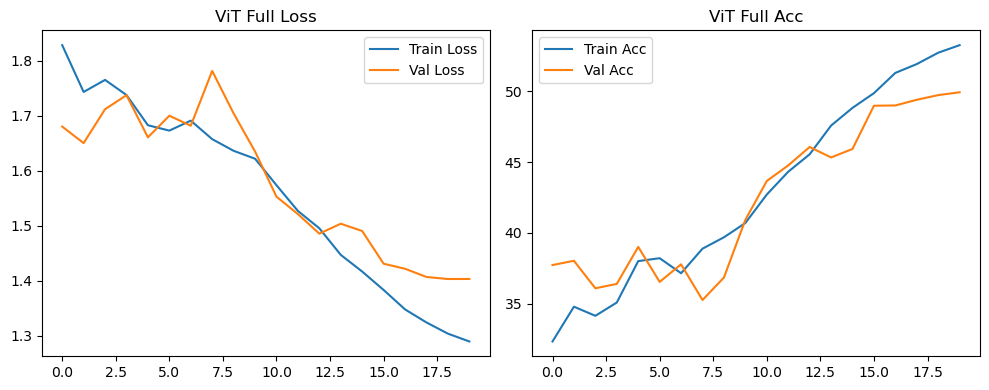

In [44]:
# Cell 14: ViT Full Graphs & GradCAM
print("\n=== Generating Training Curves and GradCAM for ViT Full ===")
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(history_vit_full['train_loss'], label='Train Loss')
plt.plot(history_vit_full['val_loss'], label='Val Loss')
plt.legend(); plt.title('ViT Full Loss')
plt.subplot(1,2,2)
plt.plot(history_vit_full['train_acc'], label='Train Acc')
plt.plot(history_vit_full['val_acc'], label='Val Acc')
plt.legend(); plt.title('ViT Full Acc')
plt.tight_layout(); plt.savefig('runs/vit_full/curves.png')


In [ ]:
# # Cell 15: SWIN Full Fine-tuning Training
# print("\n=== Training Swin Transformer (full fine-tuning) ===")
# swin_full = create_swin(pretrained=True).to(device)
# opt_swin_full = optim.AdamW(setup_model_training(swin_full, 'full_finetune'), lr=1e-3)
# history_swin_full = train_model(swin_full, train_loader, val_loader, criterion, opt_swin_full,
#                                 epochs=20, name='swin_full', out_dir='runs/swin_full')

In [ ]:
# # Cell 16: SWIN Full Evaluation
# print("\n=== Evaluating Swin Transformer (full fine-tuning) ===")
# swin_full.load_state_dict(torch.load('runs/swin_full/best_swin_full.pth'))
# evaluate_model(swin_full, test_loader, criterion, compute_metrics=True, plot_confusion=True,
#                name='SWIN Full', out_dir='runs/swin_full')


In [ ]:
# # Cell 17: SWIN Full Graphs & GradCAM
# print("\n=== Generating Training Curves and GradCAM for SWIN Full ===")
# plt.figure(figsize=(10,4))
# plt.subplot(1,2,1)
# plt.plot(history_swin_full['train_loss'], label='Train Loss')
# plt.plot(history_swin_full['val_loss'], label='Val Loss')
# plt.legend(); plt.title('SWIN Full Loss')
# plt.subplot(1,2,2)
# plt.plot(history_swin_full['train_acc'], label='Train Acc')
# plt.plot(history_swin_full['val_acc'], label='Val Acc')
# plt.legend(); plt.title('SWIN Full Acc')
# plt.tight_layout(); plt.savefig('runs/swin_full/curves.png')


Running attention map visualization...
Loading trained models...


C:\Users\user\AppData\Local\Temp\ipykernel_74760\3871777643.py:233: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  vit_head.load_state_dict(torch.load("runs/vit_head/final_vi

Loaded ViT (Head-only fine-tuning) model


C:\Users\user\AppData\Local\Temp\ipykernel_74760\3871777643.py:246: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  vit_full.load_state_dict(torch.load("runs/vit_full/final_vi

Loaded ViT (Full fine-tuning) model


C:\Users\user\AppData\Local\Temp\ipykernel_74760\3871777643.py:259: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  swin_full.load_state_dict(torch.load("runs/swin_head/final_

Loaded SWIN (Head-only fine-tuning) model


C:\Users\user\AppData\Local\Temp\ipykernel_74760\3871777643.py:272: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  swin_head.load_state_dict(torch.load("runs/swin_full/final_

Error loading SWIN Full model: [Errno 2] No such file or directory: 'runs/swin_full/final_swin_full.pth'
Getting test samples...
Files already downloaded and verified
SWIN heatmap shape: (7, 7)
SWIN heatmap shape: (7, 7)
SWIN heatmap shape: (7, 7)
SWIN heatmap shape: (7, 7)
SWIN heatmap shape: (7, 7)
SWIN heatmap shape: (7, 7)
SWIN heatmap shape: (7, 7)
SWIN heatmap shape: (7, 7)
SWIN heatmap shape: (7, 7)
SWIN heatmap shape: (7, 7)
Saved attention visualizations to visualizations/attention_maps/attention_visualization.png


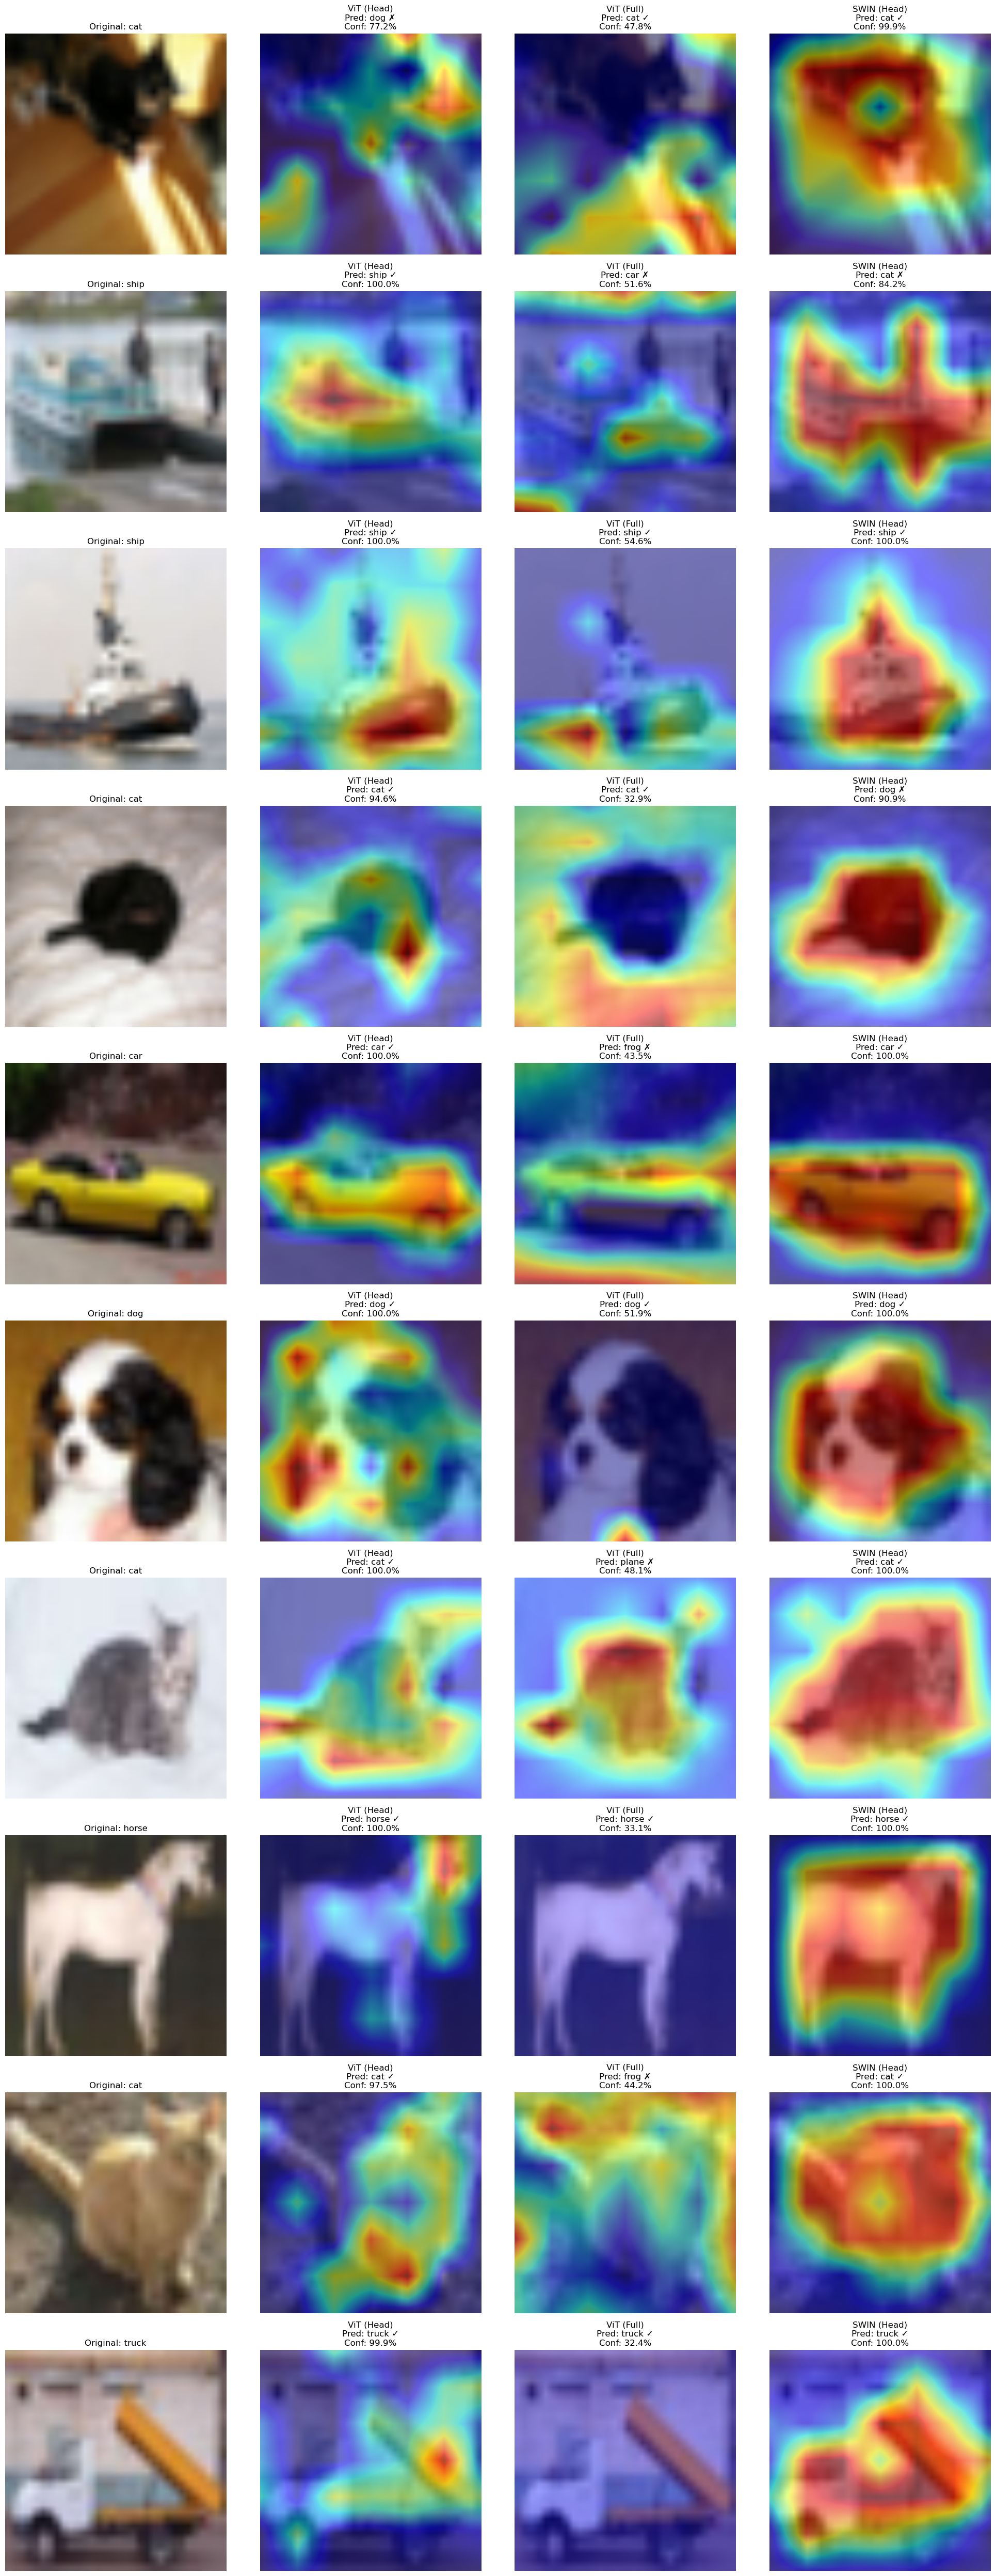

In [47]:
# Run both visualization and analysis
if __name__ == "__main__":
    print("Running attention map visualization...")
    visualize_models_attention()


In [51]:
# Cell 18: Summary of Results
def summarize_results():
    print("Model Performance Summary:")
    print(f"ViT Head-only: {history_vit_head['train_acc'][-1]:.2f}%")
    print(f"SWIN Head-only: {history_swin_head['train_acc'][-1]:.2f}%")
    print(f"ViT Full Fine-tune: {history_vit_full['train_acc'][-1]:.2f}%")
    #print(f"SWIN Full Fine-tune: {history_swin_full['val_acc'][-1]:.2f}%")
    print("\nBest Validation Accuracy:")
    print(f"ViT Head-only: {max(history_vit_head['val_acc']):.2f}%")
    print(f"SWIN Head-only: {max(history_swin_head['val_acc']):.2f}%")
    print(f"ViT Full Fine-tune: {max(history_vit_full['val_acc']):.2f}%")
    #print(f"SWIN Full Fine-tune: {max(history_swin_full['val_acc']):.2f}%")
    print("\nModel Test Accuracy:")
    print(f"ViT Head-only: 93.52%")
    print(f"SWIN Head-only: 95.55%")
    print(f"ViT Full Fine-tune: 48.60%")
    #print(f"SWIN Full Fine-tune: {max(history_swin_full['val_acc']):.2f}%")
summarize_results()

Model Performance Summary:
ViT Head-only: 97.95%
SWIN Head-only: 99.80%
ViT Full Fine-tune: 53.24%

Best Validation Accuracy:
ViT Head-only: 93.81%
SWIN Head-only: 96.22%
ViT Full Fine-tune: 49.92%

Model Test Accuracy:
ViT Head-only: 93.52%
SWIN Head-only: 95.55%
ViT Full Fine-tune: 48.60%
